In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [9]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=10

In [3]:
#load a dataset of images from a directory structure into a TensorFlow dataset
dataset=tf.keras.preprocessing.image_dataset_from_directory(  
    "PlantVillage",
    shuffle=True,   #model doesn't learn patterns from the order of the images, improving the generalization.
    image_size=(IMAGE_SIZE,IMAGE_SIZE),  #resize images to a fixed size 
    batch_size=BATCH_SIZE, # how many images will be processed in one forward/backward pass through the model
)


Found 2152 files belonging to 3 classes.


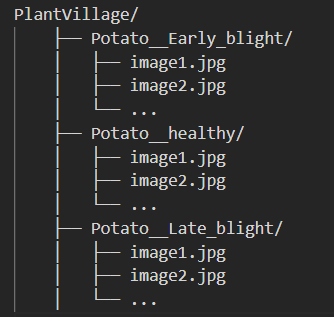

In [4]:
class_names=dataset.class_names
print(class_names)

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [5]:
len(dataset) #number of batches in the dataset
# one batch has 32 images, so 2152 images means 2152/32=67.25 batches
# 67 batches will have 32 images, and the last batch will have 8 images
# so total number of batches will be 67+1=68

68

In [6]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch[0])  #outputs a tensor
    print(image_batch[0].numpy())  #outputs a numpy array

tf.Tensor(
[[[144. 138. 150.]
  [149. 143. 155.]
  [139. 133. 145.]
  ...
  [124. 114. 125.]
  [124. 114. 125.]
  [125. 115. 126.]]

 [[155. 149. 161.]
  [144. 138. 150.]
  [154. 148. 160.]
  ...
  [119. 109. 120.]
  [120. 110. 121.]
  [120. 110. 121.]]

 [[140. 134. 146.]
  [152. 146. 158.]
  [138. 132. 144.]
  ...
  [116. 106. 117.]
  [117. 107. 118.]
  [118. 108. 119.]]

 ...

 [[167. 156. 164.]
  [168. 157. 165.]
  [168. 157. 165.]
  ...
  [111.  98. 107.]
  [110.  97. 106.]
  [102.  89.  98.]]

 [[168. 157. 165.]
  [168. 157. 165.]
  [166. 155. 163.]
  ...
  [114. 101. 110.]
  [109.  96. 105.]
  [118. 105. 114.]]

 [[167. 156. 164.]
  [165. 154. 162.]
  [161. 150. 158.]
  ...
  [115. 102. 111.]
  [108.  95. 104.]
  [132. 119. 128.]]], shape=(256, 256, 3), dtype=float32)
[[[144. 138. 150.]
  [149. 143. 155.]
  [139. 133. 145.]
  ...
  [124. 114. 125.]
  [124. 114. 125.]
  [125. 115. 126.]]

 [[155. 149. 161.]
  [144. 138. 150.]
  [154. 148. 160.]
  ...
  [119. 109. 120.]
  [120. 11

In [7]:
for image_batch,labels_batch in dataset.take(1):
    print(image_batch[0].shape)  #outputs (256,256,3) which means 256x256 pixels and 3 channels (RGB)

(256, 256, 3)


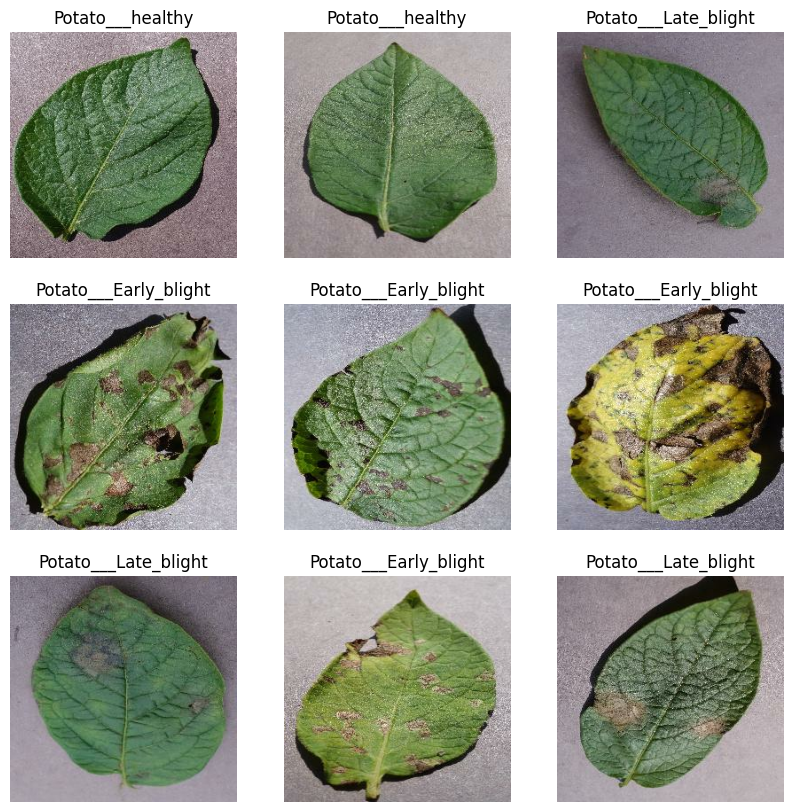

In [8]:
plt.figure(figsize=(10,10))
for image_batch,labels_batch in dataset.take(1):
    for i in range(9): 
        ax=plt.subplot(3,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))  #show the image
        plt.title(class_names[labels_batch[i]])  #show the label
        plt.axis("off")  #remove axis


 - 80% ==> training
 - 20% ==> 10% validation, 10% test

In [10]:
train_size=0.8
len(dataset)*train_size 

54.400000000000006

In [11]:
train_ds=dataset.take(54)
len(train_ds)  #54 batches

54

In [12]:
test_ds=dataset.skip(54)
len(test_ds)  #14 batches

14

In [13]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds=test_ds.take(6) 
len(val_ds)  #6 batches

6

In [15]:
test_ds=test_ds.take(8)
len(test_ds)  #8 batches

8

In [16]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)

    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(ds_size*train_split)
    val_size=int(ds_size*val_split)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)

    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds
    

In [17]:
train_ds,val_ds,test_ds= get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)  #54 batches

54

In [19]:
len(val_ds)  #6 batches

6

In [20]:
len(test_ds)  #8 batches

8

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

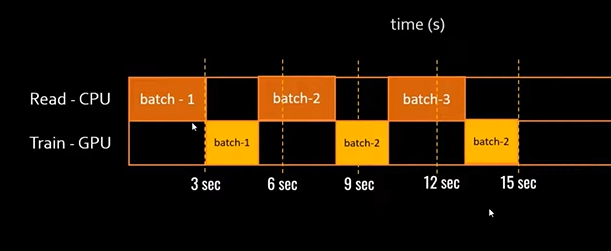
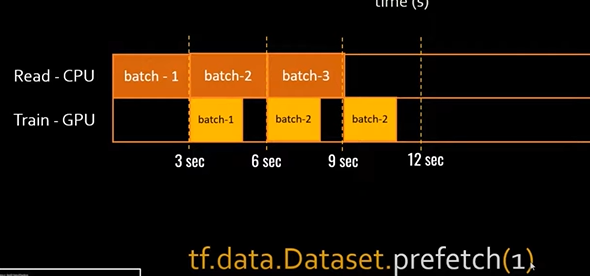

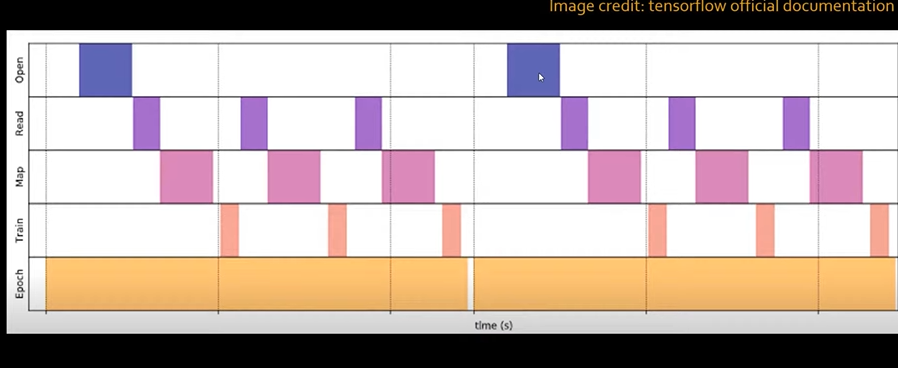
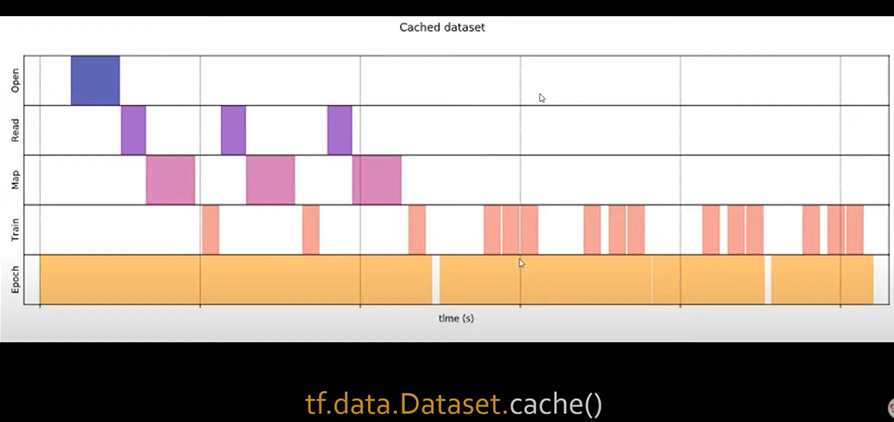

In [22]:
resize_and_rescale=tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1./255)
])

In [23]:
data_augmentation=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])

In [24]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax")
])

model.build(input_shape)


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [25]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 2304)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 277,891 (1.06 MB)

 Trainable params: 277,891 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [27]:
history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1 #verbose parameter controls how much information is shown during each epoch
)

Epoch 1/10


C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\keras\src\backend\tensorflow\nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 654ms/step - accuracy: 0.4454 - loss: 0.9494 - val_accuracy: 0.7344 - val_loss: 0.7859
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 707ms/step - accuracy: 0.7341 - loss: 0.6874 - val_accuracy: 0.7604 - val_loss: 0.5150
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 747ms/step - accuracy: 0.8331 - loss: 0.3880 - val_accuracy: 0.8958 - val_loss: 0.3010
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 741ms/step - accuracy: 0.8854 - loss: 0.2742 - val_accuracy: 0.8906 - val_loss: 0.3236
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 711ms/step - accuracy: 0.9317 - loss: 0.1994 - val_accuracy: 0.8594 - val_loss: 0.4135
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 708ms/step - accuracy: 0.9013 - loss: 0.2478 - val_accuracy: 0.8958 - val_loss: 0.2441
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 755ms/step - accuracy: 0.9394 - loss: 0.1721 - val_accuracy: 0.8229 - val_loss: 0.4338
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 773ms/step - accuracy: 0.8766 - loss: 0.3104 - val_accuracy: 0.953

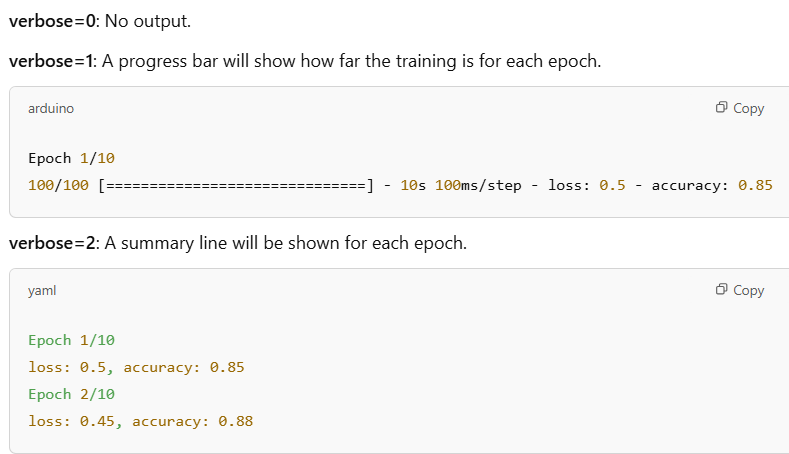

In [28]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 234ms/step - accuracy: 0.9794 - loss: 0.0692


In [29]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [30]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [31]:
history.history['accuracy']

[0.4982638955116272,
 0.7685185074806213,
 0.8570601940155029,
 0.8888888955116272,
 0.9097222089767456,
 0.9172453880310059,
 0.9299768805503845,
 0.8958333134651184,
 0.9351851940155029,
 0.9438657164573669]

In [32]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

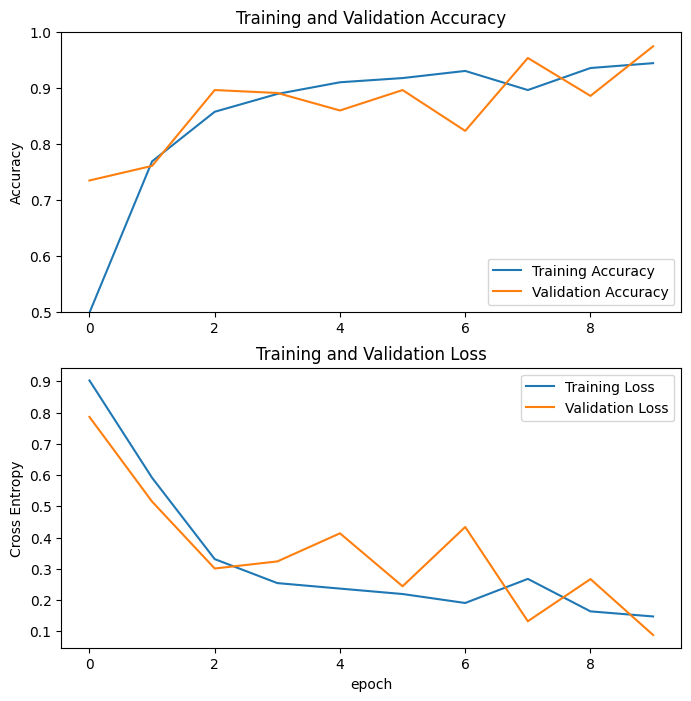

In [33]:
# Plot training & validation accuracy values
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.title('Training and Validation Accuracy')

# Plot training & validation loss values
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


first image to predict
actual label: Potato___Early_blight
predicted_label: Potato___Early_blight


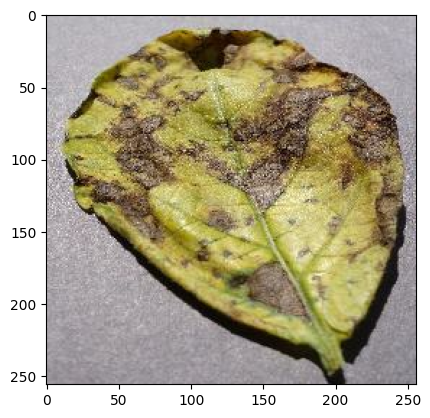

In [34]:
import numpy as np
for images_batch,labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    first_label=labels_batch[0].numpy()
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction=model.predict(images_batch,verbose=0)
    print("predicted_label:",class_names[np.argmax(batch_prediction[0])])

In [41]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0) # Create a batch
    predictions=model.predict(img_array,verbose=0)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence = str(np.max(np.array(predictions[0])) * 100)
    confidence = confidence[:confidence.index('.')+3] 
    return predicted_class,confidence

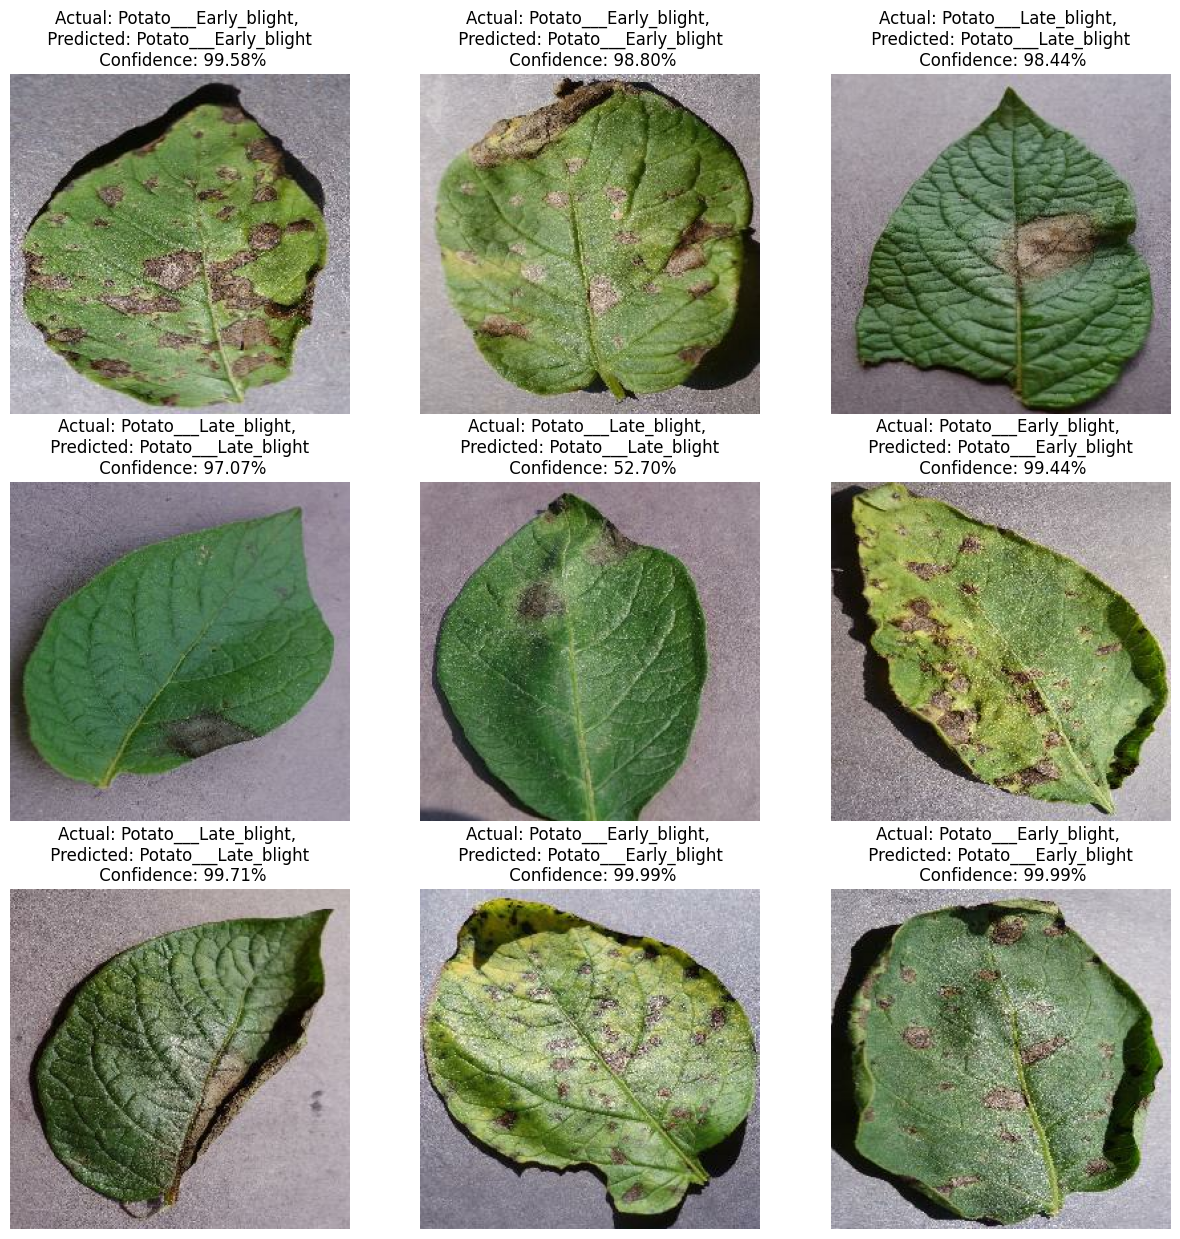

In [42]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class} \n Confidence: {confidence}%")
        plt.axis("off")

In [53]:
model_version=1
model.save(f"../models/plant_village_model_v{model_version}.keras")